In [492]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [494]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',  # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x


def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image,
                    [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                     {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                     {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                     {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16 + i * 3},
            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17 + i * 3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [
            {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41 + i * 3},
            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42 + i * 3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [
            {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66 + i * 3},
            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67 + i * 3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}],
                    skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 80},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                               'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}],
                    skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}],
                    skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                               'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 96}],
                    skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True,
                                'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False,
                                'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model


class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset - size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(size)  # bias
                    gamma = self.read_bytes(size)  # scale
                    mean = self.read_bytes(size)  # mean
                    var = self.read_bytes(size)  # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2, 3, 1, 0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0
# define the model
model = make_yolov3_model() # type: ignore
# load the model weights
weight_reader = WeightReader('yolov3 .weights') # type: ignore
# set the model weights into the model
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [495]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)   │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_0 (Conv2D)               │ (None, None, None, 32)    │             864 │ input_layer_17[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_0 (BatchNormalization)  │ (None, None, None, 32)    │             128 │ conv_0[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_0 (LeakyReLU)           │ (None, None, None, 32)    │               0 │ bnorm_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_37             │ (None, None, None, 32)    │               0 │ leaky_0[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_1 (Conv2D)               │ (None, None, None, 64)    │          18,432 │ zero_padding2d_37[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_1 (BatchNormalization)  │ (None, None, None, 64)    │             256 │ conv_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_1 (LeakyReLU)           │ (None, None, None, 64)    │               0 │ bnorm_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_2 (Conv2D)               │ (None, None, None, 32)    │           2,048 │ leaky_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_2 (BatchNormalization)  │ (None, None, None, 32)    │             128 │ conv_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_2 (LeakyReLU)           │ (None, None, None, 32)    │               0 │ bnorm_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_3 (Conv2D)               │ (None, None, None, 64)    │          18,432 │ leaky_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_3 (BatchNormalization)  │ (None, None, None, 64)    │             256 │ conv_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_3 (LeakyReLU)           │ (None, None, None, 64)    │               0 │ bnorm_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_95 (Add)                  │ (None, None, None, 64)    │               0 │ leaky_1[0][0],             │
│                               │                           │                 │ leaky_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_38             │ (None, None, None, 64)    │               0 │ add_95[0][0]               │
│ (ZeroPadding2D)               │                           │               

 Total params: 62,001,757 (236.52 MB)

 Trainable params: 61,949,149 (236.32 MB)

 Non-trainable params: 52,608 (205.50 KB)

In [498]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"] 

In [500]:
#labels='coco.names'   
ANCHORS = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
THRED_SOCRE=0.6
NMS_SCORE=0.7
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

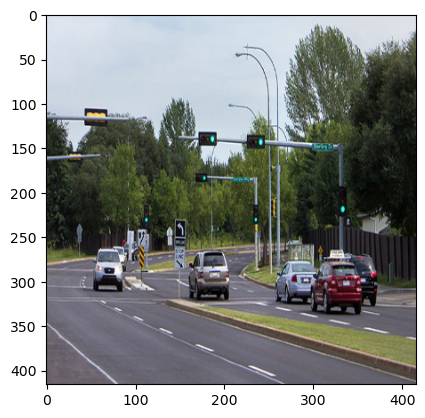

In [502]:
photo_filename='traffic.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)

In [504]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [506]:
def _decode_box_coor(box):
    return (box.xmin, box.ymin, box.xmax, box.ymax)


def _iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = _decode_box_coor(box1)
    (box2_x1, box2_y1, box2_x2, box2_y2) = _decode_box_coor(box2)

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = xi2 - xi1
    inter_height = yi2 - yi1
    inter_area = max(inter_height, 0) * max(inter_width, 0)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

def do_nms(data_dic, nms_thresh):
    final_boxes, final_scores, final_labels = list(), list(), list()
    for label in data_dic:
        scores_boxes = sorted(data_dic[label], reverse=True)
        for i in range(len(scores_boxes)):
            if scores_boxes[i][2] == 'removed': continue
            for j in range(i + 1, len(scores_boxes)):
                if _iou(scores_boxes[i][1], scores_boxes[j][1]) >= nms_thresh:
                    scores_boxes[j][2] = "removed"

        for e in scores_boxes:
            print(label + ' ' + str(e[0]) + " status: " + e[2])
            if e[2] == 'kept':
                final_boxes.append(e[1])
                final_labels.append(label)
                final_scores.append(e[0])

    return (final_boxes, final_labels, final_scores)


In [508]:
class BoundBox:
    
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score


In [510]:

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def decode_netout(netout, anchors, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2])
    netout[..., 4:] = _sigmoid(netout[..., 4:])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]

    for i in range(grid_h * grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            # if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w  # center position, unit: image width
            y = (row + y) / grid_h  # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w  # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h  # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
            boxes.append(box)
    return boxes
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

def box_filter(boxes, labels=labels, threshold_socre=THRED_SOCRE):
    valid_boxes = []
    valid_labels = []
    valid_scores = []
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > threshold_socre:
                valid_boxes.append(box)
                valid_labels.append(labels[i])
                valid_scores.append(box.classes[i])

    return (valid_boxes, valid_labels, valid_scores)



In [512]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def encoder_dic(valid_data):
    data_dic = {}
    (valid_boxes, valid_labels, valid_scores) = valid_data
    for box, label, score in zip(valid_boxes, valid_labels, valid_scores):
        if label not in data_dic:
            data_dic[label] = [[score, box, 'kept']]
        else:
            data_dic[label].append([score, box, 'kept'])

    return data_dic

def draw_boxes(filename, valid_data):

    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for i in range(len(valid_data[0])):
        box = valid_data[0][i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        print(valid_data[1][i], valid_data[2][i])
        label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()

In [514]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
    boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [516]:
print(len(boxes))

10647


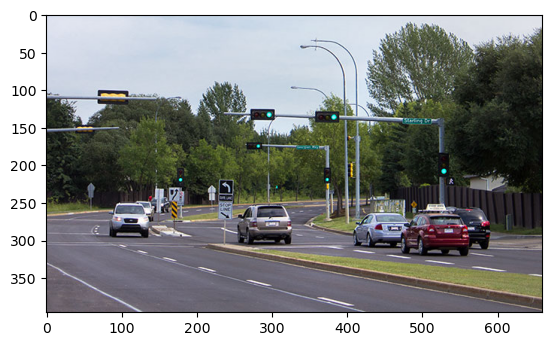

In [520]:

def draw_boxes(filename, valid_data):

    data = pyplot.imread(filename)
    pyplot.imshow(data)
    ax = pyplot.gca()
    for i in range(len(valid_data[0])):
        box = valid_data[0][i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        print(valid_data[1][i], valid_data[2][i])
        label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()
     

draw_boxes(photo_filename,valid_data)

def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
      
  return data_dic
dic=encoder_dic(valid_data)

def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area 

  iou = inter_area/union_area
  
  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])
  return (final_boxes,final_labels,final_scores)

final_data=do_nms(dic, 0.7)

Where is your image path? 
 traffic.jpg


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)          │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_0 (Conv2D)               │ (None, None, None, 32)    │             864 │ input_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_0 (BatchNormalization)  │ (None, None, None, 32)    │             128 │ conv_0[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_0 (LeakyReLU)           │ (None, None, None, 32)    │               0 │ bnorm_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, None, None, 32)    │               0 │ leaky_0[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_1 (Conv2D)               │ (None, None, None, 64)    │          18,432 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_1 (BatchNormalization)  │ (None, None, None, 64)    │             256 │ conv_1[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_1 (LeakyReLU)           │ (None, None, None, 64)    │               0 │ bnorm_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_2 (Conv2D)               │ (None, None, None, 32)    │           2,048 │ leaky_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_2 (BatchNormalization)  │ (None, None, None, 32)    │             128 │ conv_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_2 (LeakyReLU)           │ (None, None, None, 32)    │               0 │ bnorm_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_3 (Conv2D)               │ (None, None, None, 64)    │          18,432 │ leaky_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bnorm_3 (BatchNormalization)  │ (None, None, None, 64)    │             256 │ conv_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_3 (LeakyReLU)           │ (None, None, None, 64)    │               0 │ bnorm_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, None, None, 64)    │               0 │ leaky_1[0][0],             │
│                               │                           │                 │ leaky_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, None, None, 64)    │               0 │ add[0][0]                  │
│ (ZeroPadding2D)               │                           │               

 Total params: 62,001,757 (236.52 MB)

 Trainable params: 61,949,149 (236.32 MB)

 Non-trainable params: 52,608 (205.50 KB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
car 0.9982241 status: kept
car 0.98843783 status: kept
car 0.9845722 status: removed
car 0.9822434 status: kept
car 0.98184437 status: removed
car 0.98158294 status: kept
car 0.98154813 status: removed
car 0.9799808 status: removed
car 0.9342798 status: kept
car 0.93157935 status: removed
car 0.92317045 status: removed
car 0.9050933 status: removed
car 0.90150255 status: removed
car 0.8808287 status: removed
car 0.82281196 status: removed
car 0.7852914 status: kept
car 0.7668627 status: kept
car 0.6597399 status: removed
car 0.60208833 status: removed
traffic light 0.964606 status: kept
traffic light 0.87137055 status: kept
traffic light 0.8328067 status: kept
traffic light 0.77623147 status: kept
traffic light 0.75971967 status: kept
traffic light 0.70200646 status: removed
traffic light 0.618828 status: removed
car 0.9982241
car 0.98843783
car 0.9822434
car 0.98158294
car 0.9342798
car 0.7852914
car 0.7668627
traffic light 0.964606
traffic lig

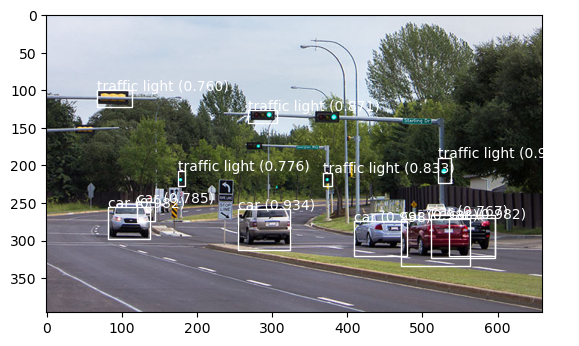

In [524]:
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import load_img # type: ignore
from numpy import expand_dims # type: ignore

class Detector():
    def __init__(self,model_path='yolov3.h5'):
        self.model=tf.keras.models.load_model(model_path)
        print(self.model.summary())

    def _load_and_preprocess_image(self, image_path):
        image = tf.io.read_file(image_path)
        image_width, image_height = load_img(image_path).size
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMAGE_WIDTH,IMAGE_HEIGHT])
        image /= 255

        return image, image_width, image_height

    def _predict(self, image):
        image_x = expand_dims(image, 0)
        yhat = self.model.predict(image_x)
        return yhat

    def _conver_to_boxes(self,yhat, image_width,image_height):
        boxes = list()
        for i in range(len(yhat)):
            boxes += decode_netout(yhat[i][0], ANCHORS[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

        for i in range(len(boxes)):
            x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH) / 2. / IMAGE_HEIGHT, float(IMAGE_WIDTH) / IMAGE_WIDTH
            y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT) / 2. / IMAGE_HEIGHT, float(IMAGE_HEIGHT) / IMAGE_HEIGHT
            boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_width)
            boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_width)
            boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_height)
            boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_height)

        return boxes

    def do_detect(self,image_path):
        image, image_width, image_height=self._load_and_preprocess_image(image_path)
        yhat=self._predict(image)
        boxes=self._conver_to_boxes(yhat,image_width,image_height)
        dic = encoder_dic(box_filter(boxes))
        valid_data=do_nms(dic,NMS_SCORE)
        draw_boxes(image_path,valid_data)

if __name__=="__main__":
    path = input("Where is your image path? \n")
    D=Detector()
    D.do_detect(image_path=path)
